### Load packages

In [1]:
import sys
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import os
import cv2
import pandas as pd

import pathlib
import hydra
from hydra import initialize, compose


In [2]:
sys.path.append('../')

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import (LinearRegression, Ridge,
                                  Lasso, ElasticNet,
                                  LassoCV, RidgeCV, ElasticNetCV,
                                  LogisticRegression)
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
import sklearn
from sklearn import svm
from sklearn import metrics
from sklearn.datasets import make_regression
from sklearn.model_selection import (train_test_split,
                                     RandomizedSearchCV,
                                     GridSearchCV,
                                     cross_validate, cross_val_score,
                                     cross_val_predict)

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold 
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegressionCV, RidgeClassifierCV


import lightgbm
from xgboost import XGBClassifier

import pandas as pd
import requests
import io
import re

import warnings


/home/abiricz/.local/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [4]:
from src import table_proc

### Init from conf file

In [5]:
initialize('../src/conf/') # Assume the configuration file is in the current folder
cfg = compose(config_name='train_pop_avg')

In [6]:
cfg

{'img_height': 246, 'img_width': 503, 'segmentation_base_path': '/mnt/ncshare/ai4covid_hackathon/preprocessed_data/train/segmented', 'preprocessed_image_base_path': '/mnt/ncshare/ai4covid_hackathon/preprocessed_data/train/aligned', 'fourier_base_path': '/mnt/ncshare/ai4covid_hackathon/preprocessed_data/train/fourier', 'brixia_score_base_path': '/mnt/ncshare/ai4covid_hackathon/preprocessed_data/train/score_original', 'train_table': '/home/qbeer/GitHub/ai4covid/data/preprocessed_data/tables/pop_avg/trainClinDataImputedPopAvg.csv', 'valid_table': '/home/qbeer/GitHub/ai4covid/data/preprocessed_data/tables/pop_avg/trainClinDataImputedPopAvg.csv', 'test_table': '/home/qbeer/GitHub/ai4covid/data/preprocessed_data/tables/pop_avg/testClinDataImputedPopAvg.csv', 'raw_output_base': '/mnt/ncshare/ai4covid_hackathon/raw_output', 'project': 'ai4covid', 'n_feature_cols': 41, 'visualize': True, 'augment': True, 'batch_size': 9, 'epochs': 47, 'learning_rate': 0.01074, 'steps_per_epoch': 365, 'death_rat

In [7]:
cfg.preprocessed_image_base_path, cfg.train_table, cfg.valid_table

('/mnt/ncshare/ai4covid_hackathon/preprocessed_data/train/aligned',
 '/home/qbeer/GitHub/ai4covid/data/preprocessed_data/tables/pop_avg/trainClinDataImputedPopAvg.csv',
 '/home/qbeer/GitHub/ai4covid/data/preprocessed_data/tables/pop_avg/trainClinDataImputedPopAvg.csv')

In [8]:
preproc_df = pd.read_csv( cfg.train_table )
preproc_df.Prognosis.replace('SEVERE', 1, inplace=True)
preproc_df.Prognosis.replace('MILD', 0, inplace=True)
preproc_df.head()

,ImageFile,Age,Sex,PositivityAtAdmission,Temp_C,DaysFever,Cough,DifficultyInBreathing,WBC,RBC,...,Obesity,Position,Prognosis,Death,Hospital_A,Hospital_B,Hospital_C,Hospital_D,Hospital_E,Hospital_F
0,P_102.png,0.490163,1,1,-0.256402,0.271422,1,0,-0.451167,0.011004,...,0,0,1,0,1,0,0,0,0,0
1,P_131.png,-1.900581,0,1,1.779697,0.271422,1,0,-0.349484,0.942178,...,1,0,0,0,0,0,0,1,0,0
2,P_132.png,-0.485936,0,1,-0.561816,0.271422,0,0,1.141870,1.605287,...,0,0,0,0,0,0,0,1,0,0
3,P_117.png,-1.696123,1,1,-0.358206,-0.708205,1,0,0.800319,-1.583279,...,0,1,0,0,1,0,0,0,0,0
4,P_16.png,-1.364867,0,1,0.456233,0.271422,1,0,-0.120045,1.379548,...,0,0,1,0,1,0,0,0,0,0


In [9]:
X_df = preproc_df.drop( columns=['ImageFile', 'Prognosis', 'Death'])
X_features = X_df.columns
X = X_df.values
y = preproc_df[ ['Prognosis', 'Death'] ].values
X[:1], y[:3]

(array([[ 0.49016307,  1.        ,  1.        , -0.25640158,  0.27142168,
          1.        ,  0.        , -0.45116693,  0.01100365, -0.48483956,
          0.        , -0.44498231,  0.        ,  0.        , -0.10419858,
          0.        ,  0.05422478, -0.36488865,  0.07532383,  0.09652249,
          0.04815052,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ]]),
 array([[1, 0],
        [0, 0],
        [0, 0]]))

#### The score used for ranking is the accuracy value of the proposed classification on the test set. Please note that the proportion of classes may vary between training and test sets.

In [10]:
X.shape, y.shape

((1103, 41), (1103, 2))

[0.12123624 0.08708214 0.06999677]


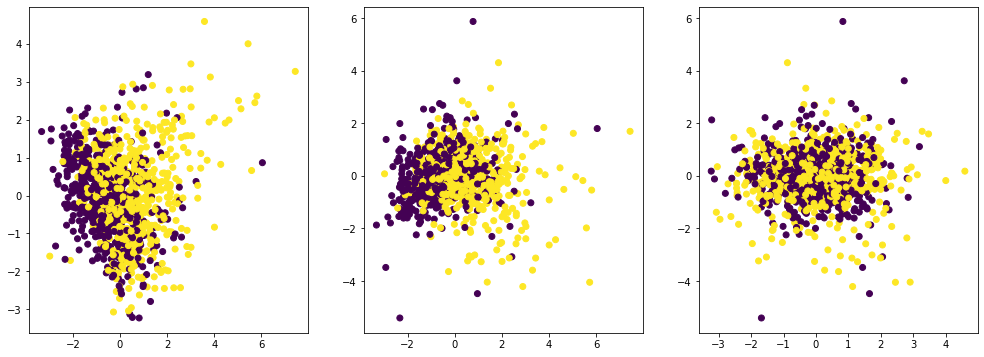

In [11]:
pca = PCA(3)
pca_transformed = pca.fit_transform(X)
print(pca.explained_variance_ratio_)

plt.figure(figsize=(17, 6))
plt.subplot(131)
plt.scatter(pca_transformed[:,0], pca_transformed[:,1], c=y[:,0])

plt.subplot(132)
plt.scatter(pca_transformed[:,0], pca_transformed[:,2], c=y[:,0])

plt.subplot(133)
plt.scatter(pca_transformed[:,1], pca_transformed[:,2], c=y[:,0])

### Scores to evaluate with

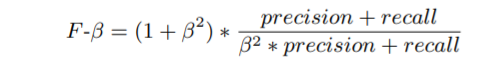

### Evaluate some models to test

In [12]:
def kfold_model_eval( model, k=5 ):
    kf = KFold(n_splits=k, random_state=None)
    try:
        model = model(n_jobs=8)
    except:
        model = model()
    
    acc_score = []

    for train_index , test_index in kf.split(X):
        X_train , X_test = X[train_index,:], X[test_index,:]
        y_train , y_test = y[train_index, 0] , y[test_index, 0]

        model.fit(X_train,y_train)
        pred_values = model.predict(X_test)

        #acc = metrics.fbeta_score(pred_values , y_test, beta=2)
        acc = metrics.roc_auc_score(pred_values , y_test)
        acc_score.append(acc)

    avg_acc_score = sum(acc_score)/k

    print('accuracy of each fold - {}'.format(acc_score))
    print('Avg accuracy : {}'.format(avg_acc_score))

In [13]:
warnings.filterwarnings(action='ignore')
kfold_model_eval(LogisticRegression)
kfold_model_eval(svm.SVC)
kfold_model_eval(RandomForestClassifier)
kfold_model_eval(GradientBoostingClassifier)
kfold_model_eval(lightgbm.LGBMClassifier )
kfold_model_eval(XGBClassifier )

accuracy of each fold - [0.7605042016806722, 0.7136752136752137, 0.7504967709885743, 0.718468282193367, 0.7924891267982602]
Avg accuracy : 0.7471267190672175
accuracy of each fold - [0.7780917280917281, 0.7328828828828828, 0.7691268020969856, 0.6757187159500461, 0.7511578947368421]
Avg accuracy : 0.741395604751697
accuracy of each fold - [0.7218082463984103, 0.7434005574684375, 0.7645853818420191, 0.7011036428512156, 0.7971670438353868]
Avg accuracy : 0.7456129744790939
accuracy of each fold - [0.7370413032746421, 0.709985255570118, 0.7205665024630543, 0.6699999999999999, 0.7657493368700266]
Avg accuracy : 0.7206684796355682
accuracy of each fold - [0.7720443349753695, 0.7196150696150697, 0.7429450369155046, 0.6941580756013745, 0.7700605758858187]
Avg accuracy : 0.7397646185986274
[16:38:21] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric

### Feature importance

In [15]:
def do_rfe_with_cv( regressor, X, y, n_features_to_select=20 ):
    rfe = RFE( estimator=regressor, n_features_to_select=n_features_to_select, step=1 )
    rfe = rfe.fit(X, y)
    return rfe

In [16]:
def get_explanining_variables( selector, original_feature_columns, X_test, y_test ):
    return sorted( original_feature_columns[selector.support_].values.tolist() ),\
           selector.score(X_test, y_test),\
           selector.predict(X_test)

In [17]:
X_train, X_test, y_train, y_test = train_test_split( X, y[:,0], test_size=.1, random_state=42 )

### Subset selected for further fits

#### only 20 best

In [18]:
exp_logi, logi_test_score, logi_preds = get_explanining_variables(
    do_rfe_with_cv(LogisticRegressionCV(cv=5, n_jobs=8), X_train, y_train),
                    X_features, X_test, y_test)
exp_logi

['Age',
 'CRP',
 'ChronicKidneyDisease',
 'Diabetes',
 'DifficultyInBreathing',
 'Hospital_A',
 'Hospital_B',
 'Hospital_C',
 'Hospital_D',
 'Hospital_E',
 'Hospital_F',
 'Ictus',
 'LDH',
 'Obesity',
 'Ox_percentage',
 'PCT',
 'Position',
 'PositivityAtAdmission',
 'SaO2',
 'Sex']

In [19]:
X = preproc_df[ exp_logi ].values

warnings.filterwarnings(action='ignore')
kfold_model_eval(LogisticRegression)
kfold_model_eval(svm.SVC)
kfold_model_eval(RandomForestClassifier)
kfold_model_eval(GradientBoostingClassifier)
kfold_model_eval(lightgbm.LGBMClassifier)
kfold_model_eval(XGBClassifier)

accuracy of each fold - [0.7327070169604257, 0.71543250327654, 0.7494224422442244, 0.7236405835543767, 0.7925]
Avg accuracy : 0.7427405092071134
accuracy of each fold - [0.7477056702720419, 0.7190366972477064, 0.7696247132087841, 0.6869867073067479, 0.7979296066252588]
Avg accuracy : 0.7442566789321079
accuracy of each fold - [0.7720443349753695, 0.7377062706270627, 0.7334070796460177, 0.7259116761458682, 0.7748673740053051]
Avg accuracy : 0.7487873470799247
accuracy of each fold - [0.7734079315451703, 0.699014778325123, 0.7375102375102376, 0.725, 0.8156999419135342]
Avg accuracy : 0.750126577858813
accuracy of each fold - [0.779922938186588, 0.6899425287356322, 0.7329210353866317, 0.7125974352527031, 0.7652874709205717]
Avg accuracy : 0.7361342816964254
[16:38:56] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore t

In [20]:
X = preproc_df[ exp_logi ].values
X.shape

(1103, 20)

#### only 15 best

In [21]:
exp_logi, logi_test_score, logi_preds = get_explanining_variables(
    do_rfe_with_cv( LogisticRegressionCV(cv=5, n_jobs=8), X_train, y_train, n_features_to_select=15),
                    X_features, X_test, y_test)
exp_logi

['Age',
 'CRP',
 'ChronicKidneyDisease',
 'DifficultyInBreathing',
 'Hospital_A',
 'Hospital_B',
 'Hospital_D',
 'Hospital_E',
 'Hospital_F',
 'LDH',
 'Obesity',
 'Ox_percentage',
 'Position',
 'PositivityAtAdmission',
 'Sex']

In [22]:
X = preproc_df[ exp_logi ].values

warnings.filterwarnings(action='ignore')
kfold_model_eval(LogisticRegression)
kfold_model_eval(svm.SVC)
kfold_model_eval(RandomForestClassifier)
kfold_model_eval(GradientBoostingClassifier)
kfold_model_eval(lightgbm.LGBMClassifier)
kfold_model_eval(XGBClassifier)

accuracy of each fold - [0.7476072607260726, 0.7276602721757665, 0.7535014005602241, 0.7151046859421735, 0.787878787878788]
Avg accuracy : 0.746350481456605
accuracy of each fold - [0.7377559377559377, 0.7273325654105645, 0.760075360419397, 0.6900201612903225, 0.762219832933587]
Avg accuracy : 0.7354807715619617
accuracy of each fold - [0.7386512618813504, 0.7353037766830871, 0.7377136752136753, 0.7066666666666667, 0.7895128608055578]
Avg accuracy : 0.7415696482500673
accuracy of each fold - [0.7085385878489328, 0.6931743690593247, 0.7238481718314477, 0.6602691924227319, 0.7888198757763976]
Avg accuracy : 0.7149300393877669
accuracy of each fold - [0.7386512618813504, 0.7051820728291316, 0.7556193601312552, 0.6651135701805474, 0.7513936267576337]
Avg accuracy : 0.7231919783559837
[16:39:13] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric 

#### only 10 best

In [23]:
exp_logi, logi_test_score, logi_preds = get_explanining_variables(
    do_rfe_with_cv( LogisticRegressionCV(cv=5, n_jobs=8), X_train, y_train, n_features_to_select=10),
                    X_features, X_test, y_test)
exp_logi

['Age',
 'ChronicKidneyDisease',
 'DifficultyInBreathing',
 'Hospital_A',
 'Hospital_E',
 'LDH',
 'Obesity',
 'Ox_percentage',
 'PositivityAtAdmission',
 'Sex']

In [24]:
X = preproc_df[ exp_logi ].values

warnings.filterwarnings(action='ignore')
kfold_model_eval(LogisticRegression)
kfold_model_eval(svm.SVC)
kfold_model_eval(RandomForestClassifier)
kfold_model_eval(GradientBoostingClassifier)
kfold_model_eval(lightgbm.LGBMClassifier)
kfold_model_eval(XGBClassifier)

accuracy of each fold - [0.7605042016806722, 0.7183087027914614, 0.7605703048180924, 0.7322906322409797, 0.762219832933587]
Avg accuracy : 0.7467787348929585
accuracy of each fold - [0.7397046759639049, 0.7244839449541284, 0.7290949335956715, 0.728487262467845, 0.7581018518518519]
Avg accuracy : 0.7359745337666803
accuracy of each fold - [0.7106060606060606, 0.6750655522779417, 0.7151555043607043, 0.7108744487894167, 0.7481794107911288]
Avg accuracy : 0.7119761953650505
accuracy of each fold - [0.7176108374384236, 0.7190366972477064, 0.7284249384741591, 0.7024793388429752, 0.7839854111405835]
Avg accuracy : 0.7303074446287695
accuracy of each fold - [0.7240896358543417, 0.6820197044334975, 0.7103603603603603, 0.6941580756013745, 0.7201591511936339]
Avg accuracy : 0.7061573854886416
[16:39:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metri

#### only 5 best

In [25]:
exp_logi, logi_test_score, logi_preds = get_explanining_variables(
    do_rfe_with_cv( LogisticRegressionCV(cv=5, n_jobs=8), X_train, y_train, n_features_to_select=5),
                    X_features, X_test, y_test)
exp_logi

['ChronicKidneyDisease',
 'Hospital_A',
 'LDH',
 'Ox_percentage',
 'PositivityAtAdmission']

In [26]:
X = preproc_df[ exp_logi ].values

warnings.filterwarnings(action='ignore')
kfold_model_eval(LogisticRegression)
kfold_model_eval(svm.SVC)
kfold_model_eval(RandomForestClassifier)
kfold_model_eval(GradientBoostingClassifier)
kfold_model_eval(lightgbm.LGBMClassifier)
kfold_model_eval(XGBClassifier)

accuracy of each fold - [0.7035105149859249, 0.6733070995245122, 0.733087633087633, 0.6554642768235001, 0.701761640889918]
Avg accuracy : 0.6934262330622977
accuracy of each fold - [0.7143332224808778, 0.6910919540229884, 0.7311881188118812, 0.6547845504921015, 0.6962962962962963]
Avg accuracy : 0.697538828420829
accuracy of each fold - [0.6662159947558177, 0.6634519454605919, 0.6703510514985924, 0.644630192502533, 0.663112653938342]
Avg accuracy : 0.6615523676311754
accuracy of each fold - [0.7165109034267914, 0.6773333333333332, 0.6925833333333332, 0.6601073345259392, 0.7027368421052631]
Avg accuracy : 0.689854349344932
accuracy of each fold - [0.6933792199278924, 0.6496598639455783, 0.6947194719471947, 0.6193181818181818, 0.7043325526932084]
Avg accuracy : 0.672281858066411
[16:39:38] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if 

### Adding Fourier features

In [27]:
source_img = cfg.preprocessed_image_base_path
files_img = np.array( [ i for i in sorted( os.listdir(source_img) ) ] )
files_img[:3]

array(['P_1.png', 'P_10.png', 'P_100.png'], dtype='<U11')

In [28]:
def load_image(path, resize=False, imgsz=512):
    img = cv2.imread(path, cv2.IMREAD_ANYDEPTH)
    
    if resize:
        img = cv2.resize(
            img,
            (imgsz, imgsz),
            interpolation=cv2.INTER_AREA,
        )
    return img

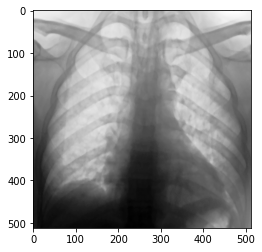

In [29]:
img = load_image( os.path.join(cfg.preprocessed_image_base_path, files_img[10]) )
plt.imshow( img, cmap='Greys' )

In [30]:
def normalize_fourier_image(img):
    img = (img - np.min(img)) / (np.max(img) - np.min(img))  # min-max scaling
    img = (img * 255).astype("uint8")
    img = cv2.medianBlur(img, 3)
    img = np.array(img) / 255.0
    return img

0.22745098039215686 0.8352941176470589


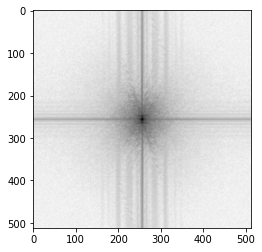

In [31]:
f = np.fft.fft2(img)
f_s = np.fft.fftshift(f)
new_img = np.log(abs(f_s))
new_img = normalize_fourier_image(new_img)
print( new_img.min(), new_img.max() )
plt.imshow( new_img, cmap='Greys' )

In [32]:
img.min(), img.max()

(12, 247)

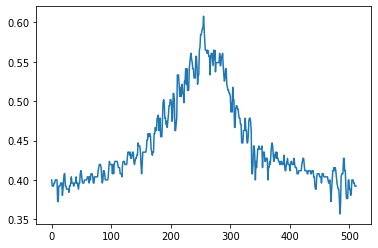

In [33]:
plt.plot( new_img[:,230] )

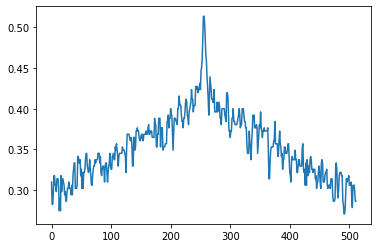

In [35]:
plt.plot( new_img[:,150] )